In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin

## Load data

In [2]:
PATH = os.getcwd()

In [3]:
raw_df = pd.read_csv(f'{PATH}/data/Airline-Sentiment-2-w-AA.csv', encoding='ISO-8859-1')

In [4]:
raw_df.shape

(14640, 20)

In [5]:
raw_df.sample(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
11181,681462477,False,finalized,3,2/25/15 8:55,positive,1.0000,NaN,NaN,US Airways,NaN,JosephPMathews,NaN,0,@USAirways #tbt every day.,NaN,2/19/15 8:47,5.684520e+17,San Francisco,Pacific Time (US & Canada)
6059,681456294,False,finalized,3,2/25/15 3:20,neutral,0.6638,NaN,0.0000,Southwest,NaN,bikermom46,NaN,0,@SouthwestAir trying to get to Mexico in Septe...,NaN,2/19/15 4:38,5.683890e+17,NaN,NaN
993,681449677,False,finalized,3,2/25/15 9:26,negative,0.6630,Customer Service Issue,0.3478,United,NaN,TuraOntheroad,NaN,0,@united Nope. Walked up &amp; down the ORF ter...,NaN,2/23/15 13:25,5.699710e+17,Brooklyn,Pacific Time (US & Canada)
10487,681461778,False,finalized,3,2/25/15 6:47,positive,0.6879,NaN,0.0000,US Airways,NaN,PinkBird,NaN,0,"@USAirways thank you! It's # 1875 from BWI, ke...",NaN,2/21/15 14:13,5.692590e+17,NaN,Mountain Time (US & Canada)
6246,681456498,False,finalized,3,2/25/15 4:53,neutral,1.0000,NaN,NaN,Southwest,NaN,oliviasdad1,NaN,0,@SouthwestAir sent,NaN,2/18/15 9:31,5.681010e+17,NaN,NaN


Null values

In [6]:
raw_df.isnull().sum()

_unit_id                            0
_golden                             0
_unit_state                         0
_trusted_judgments                  0
_last_judgment_at                  56
airline_sentiment                   0
airline_sentiment:confidence        0
negativereason                   5462
negativereason:confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_id                            0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Target class distribution

In [7]:
raw_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='whitegrid')

In [10]:
df = raw_df[['text', 'airline_sentiment']].copy()

In [11]:
df.shape

(14640, 2)

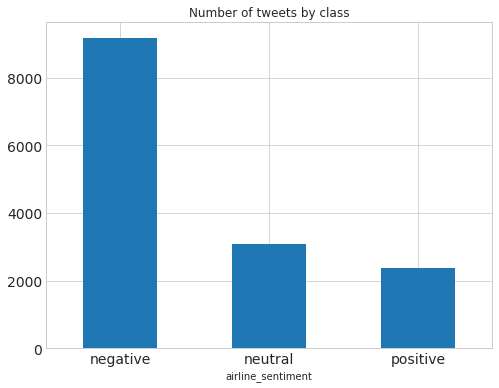

In [12]:
df.groupby(['airline_sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class');

In [13]:
pd.set_option('display.max_colwidth', -1)

In [14]:
df.sample(5)

,text,airline_sentiment
5797,@SouthwestAir I figured the streaming wouldn't work per the TOS but just the @NASCAR site is taking longer than 5 minutes to load,negative
9299,@USAirways I am so disappointed with the service I received with you on my travels to NC these past few days .. you lost my baggage twice.,negative
10870,"@USAirways I needed to be at my destination by lunchtime today. No one could get us on a flight, but I've since learned @Delta had one!",negative
4064,"@united She met me from customer service at the arrival of flight UA3787 PVD-IAD. Thanks, you guys have really handled this storm!",positive
11247,@USAirways cardholder is flying. We both have us airways and advantage cards which is more frustrating.,negative


## Preprocess data

Encode categorical label class into numerical

In [15]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['airline_sentiment'])

Text cleaning

In [16]:
ct = TextCleaner()
df['clean_text'] = ct.transform(df['text'])

Tokenizer

In [17]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stemmer = snowballstemmer.EnglishStemmer()

def tokenize(s): 
    tokens = re_tok.sub(r' \1 ', s).split()
    return stemmer.stemWords(tokens)

Train, test splitting

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'].values, df['target'].values, test_size=0.25, random_state=0)

Td-idf

In [19]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.75, min_df=3, sublinear_tf=True)

In [20]:
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

## Naive Bayes

In [21]:
def naive_bayes(x, y):
    r = []; b = []
    labels = np.unique(y)

    for l in labels:
        other_l = labels[labels != l]
        p = x[y == l].sum(0) + 1
        q = x[(y == other_l[0]) | (y == other_l[1])].sum(0) + 1
        r.append(np.log((p/p.sum())/(q/q.sum())))
        b.append(np.log(len(p)/len(q)))
    
    return r, b

In [22]:
r, b = naive_bayes(tfidf_train, y_train)

pre_preds = []
for j in range(len(r)):
    pre_preds.append(np.asarray(tfidf_test @ r[j].T + b[j]).reshape(-1))
arr = np.array(pre_preds)

In [23]:
metrics.accuracy_score(y_test, np.argmax(arr.T, 1))

0.7959016393442623

In [24]:
print(metrics.classification_report(y_test, np.argmax(arr.T, 1), target_names=le.classes_))

             precision    recall  f1-score   support

   negative       0.82      0.94      0.87      2327
    neutral       0.72      0.49      0.59       772
   positive       0.77      0.63      0.69       561

avg / total       0.79      0.80      0.78      3660



## Logistic Regression

Cross validation with 5 folds

In [25]:
scores = cross_val_score(LogisticRegression(C=4, dual=True), tfidf_train, y_train, cv=5)

In [26]:
scores

array([0.80709736, 0.79745107, 0.80546697, 0.80091116, 0.81867882])

In [27]:
np.mean(scores), np.std(scores)

(0.8059210756972217, 0.007227586380912802)

Train over complete training set

In [28]:
m = LogisticRegression(C=4, dual=True)
m.fit(tfidf_train, y_train)

LogisticRegression(C=4, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Evaluating on test set

In [29]:
preds = m.predict(tfidf_test)
(preds==y_test).mean()

0.8087431693989071

In [30]:
print(metrics.classification_report(y_test, preds, target_names=le.classes_))

             precision    recall  f1-score   support

   negative       0.83      0.94      0.88      2327
    neutral       0.71      0.54      0.62       772
   positive       0.81      0.63      0.71       561

avg / total       0.80      0.81      0.80      3660



#### Tokens importance

In [31]:
def get_tokens_coefs(vocab, coefs, n):
    coef_df = pd.DataFrame({'vocab': vocab, 'coef':coefs.reshape(-1)})
    return coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:n]

In [32]:
def plot_tokens_coefs(df, ax, label):
    df.sort_values('coef').plot.barh(legend=False, ax=ax)
    ax.set_yticklabels(df['vocab'].values.tolist()[::-1])
    ax.set_title(label);

In [40]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='white')

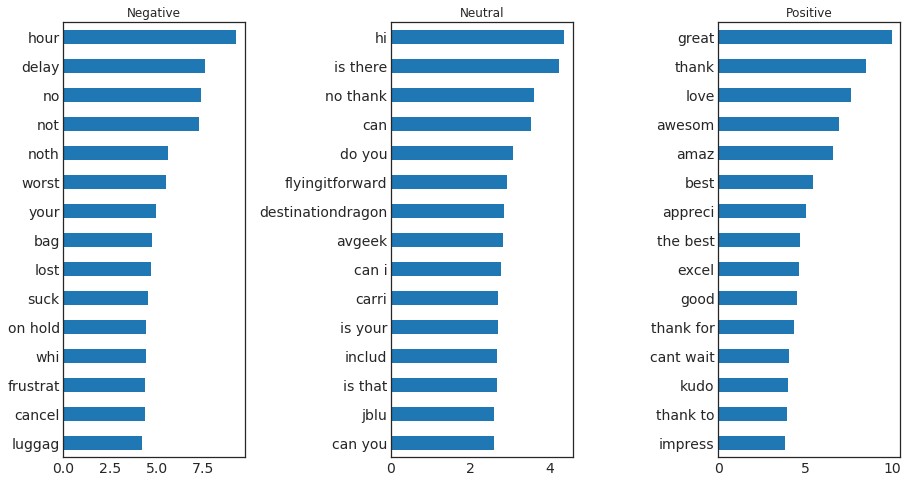

In [41]:
vocab = vect.get_feature_names()
n_coefs = 15

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.8)

for i, l in enumerate(['Negative', 'Neutral', 'Positive']):
    coef_df = get_tokens_coefs(vocab, m.coef_[i], n_coefs)
    plot_tokens_coefs(coef_df, axs[i], l)